In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.4 MB/s eta 0:00:00


**H vs (E and S)**

No Standerscaler and no opt

In [4]:
import os
import numpy as np
import pywt  # PyWavelets for wavelet decomposition
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time
import pandas as pd

# Function to perform wavelet decomposition
def wavelet_decompose(data, wavelet='db4', level=5):
    decomposed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Concatenate all coefficients to form a feature vector
        features = np.concatenate(coeffs)
        decomposed_data.append(features)
    return np.array(decomposed_data)

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (S) (1 for Epileptic/Seizure)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification (Healthy vs Epileptic + Seizure)
    ])

    # Compile the model with categorical crossentropy loss (binary classification)
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0 or 1)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='binary')  # Binary classification
    precision = precision_score(y_test, y_pred_classes, average='binary')
    f1 = f1_score(y_test, y_pred_classes, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation (True Negative / (True Negative + False Positive))
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Create results table
    results = pd.DataFrame({
        'Metric': ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'Specificity'],
        'Score': [accuracy, recall, precision, f1, specificity]
    })

    # Print evaluation results in table format
    print("\nFinal Evaluation Metrics:")
    print(results)
    print("\nConfusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.5878 - loss: 0.7033 - val_accuracy: 0.6111 - val_loss: 0.7200
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 999ms/step - accuracy: 0.6719 - loss: 0.5847 - val_accuracy: 0.6111 - val_loss: 0.6108
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7105 - loss: 0.5495 - val_accuracy: 0.6111 - val_loss: 0.5879
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7147 - loss: 0.5268 - val_accuracy: 0.7556 - val_loss: 0.4912
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7485 - loss: 0.4661 - val_accuracy: 0.7889 - val_loss: 0.4583
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7853 - loss: 0.4988 - val_accuracy: 0.6889 - val_loss: 0.5254
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8216 - loss: 0.4177 - val_accuracy: 0.7889 - val_loss: 0.4744
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 988ms/step - accuracy: 0.7344 - loss: 0.4746 - val_accuracy: 0.8000 - val_loss: 0.4236
Epoch 

With standerscaler

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.5590 - loss: 0.7059 - val_accuracy: 0.6333 - val_loss: 0.5793
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6401 - loss: 0.5876 - val_accuracy: 0.6222 - val_loss: 0.5573
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6827 - loss: 0.5338 - val_accuracy: 0.7444 - val_loss: 0.5184
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7180 - loss: 0.4922 - val_accuracy: 0.6444 - val_loss: 0.5331
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.7722 - loss: 0.4722 - val_accuracy: 0.8000 - val_loss: 0.4820
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7593 - loss: 0.4525 - val_accuracy: 0.7444 - val_loss: 0.4984
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7878 - loss: 0.4516 - val_accuracy: 0.7667 - val_loss: 0.4483
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7518 - loss: 0.4622 - val_accuracy: 0.7778 - val_loss: 0.4491
Epoch 9/3

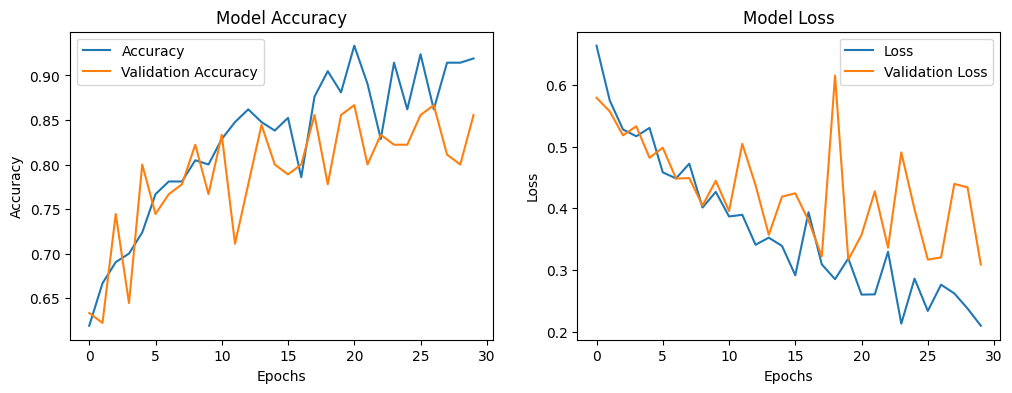

In [10]:
import os
import numpy as np
import pywt  # PyWavelets for wavelet decomposition
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time
import pandas as pd

# Function to perform wavelet decomposition
def wavelet_decompose(data, wavelet='db4', level=5):
    decomposed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Concatenate all coefficients to form a feature vector
        features = np.concatenate(coeffs)
        decomposed_data.append(features)
    return np.array(decomposed_data)

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (S) (1 for Epileptic/Seizure)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification (Healthy vs Epileptic + Seizure)
    ])

    # Compile the model with categorical crossentropy loss (binary classification)
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0 or 1)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='binary')  # Binary classification
    precision = precision_score(y_test, y_pred_classes, average='binary')
    f1 = f1_score(y_test, y_pred_classes, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation (True Negative / (True Negative + False Positive))
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Create results table
    results = pd.DataFrame({
        'Metric': ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'Specificity'],
        'Score': [accuracy, recall, precision, f1, specificity]
    })

    # Print evaluation results in table format
    print("\nFinal Evaluation Metrics:")
    print(results)
    print("\nConfusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


With Optmiser

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.5832 - loss: 0.6796 - val_accuracy: 0.6111 - val_loss: 0.6252
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6234 - loss: 0.6523 - val_accuracy: 0.6556 - val_loss: 0.5700
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6531 - loss: 0.5739 - val_accuracy: 0.6111 - val_loss: 0.5821
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7234 - loss: 0.5155 - val_accuracy: 0.6111 - val_loss: 0.5452
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7098 - loss: 0.5281 - val_accuracy: 0.6333 - val_loss: 0.5304
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7650 - loss: 0.4871 - val_accuracy: 0.7000 - val_loss: 0.5074
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7759 - loss: 0.4587 - val_accuracy: 0.8111 - val_loss: 0.4747
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7781 - loss: 0.4454 - val_accuracy: 0.8444 - val_loss: 0.4399
Epoch 9/30
7/7 ━━━━━━━━

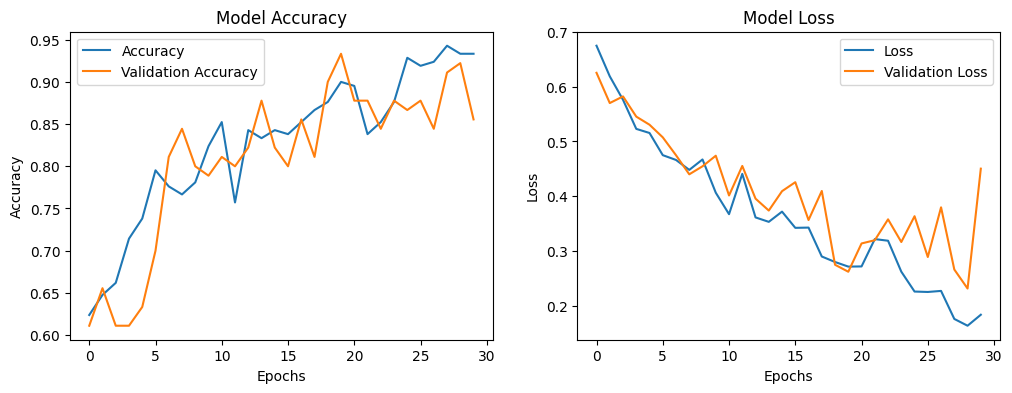

In [11]:
import os
import numpy as np
import pywt  # PyWavelets for wavelet decomposition
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time
import pandas as pd

# Function to perform wavelet decomposition
def wavelet_decompose(data, wavelet='db4', level=5):
    decomposed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Concatenate all coefficients to form a feature vector
        features = np.concatenate(coeffs)
        decomposed_data.append(features)
    return np.array(decomposed_data)

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (S) (1 for Epileptic/Seizure)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all, wavelet='db4', level=5)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification (Healthy vs Epileptic + Seizure)
    ])

    # Compile the model with Adam optimizer and sparse categorical crossentropy loss
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0 or 1)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='binary')  # Binary classification
    precision = precision_score(y_test, y_pred_classes, average='binary')
    f1 = f1_score(y_test, y_pred_classes, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation (True Negative / (True Negative + False Positive))
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Create results table
    results = pd.DataFrame({
        'Metric': ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'Specificity'],
        'Score': [accuracy, recall, precision, f1, specificity]
    })

    # Print evaluation results in table format
    print("\nFinal Evaluation Metrics:")
    print(results)
    print("\nConfusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")


with both standerscaler and op

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6576 - loss: 0.6508 - val_accuracy: 0.6111 - val_loss: 0.6291
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6942 - loss: 0.5985 - val_accuracy: 0.6111 - val_loss: 0.6138
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6778 - loss: 0.5744 - val_accuracy: 0.6111 - val_loss: 0.6055
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6714 - loss: 0.5795 - val_accuracy: 0.6111 - val_loss: 0.6137
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6916 - loss: 0.5590 - val_accuracy: 0.6111 - val_loss: 0.5752
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6858 - loss: 0.5539 - val_accuracy: 0.6111 - val_loss: 0.6074
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6681 - loss: 0.5945 - val_accuracy: 0.6444 - val_loss: 0.5714
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7012 - loss: 0.5611 - val_accuracy: 0.6111 - val_loss: 0.5792
Epoch 9/30
7/7 ━━━━━━━

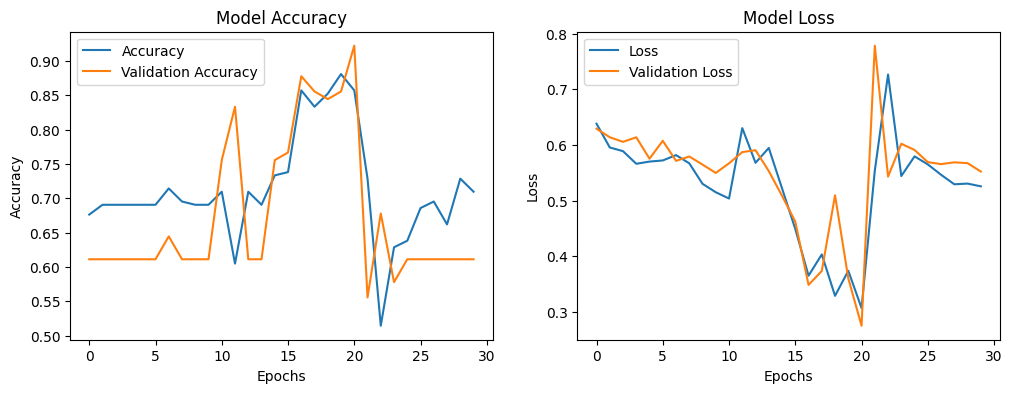

In [12]:
import os
import numpy as np
import pywt  # PyWavelets for wavelet decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # For standardization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
import time
import pandas as pd

# Function to perform wavelet decomposition
def wavelet_decompose(data, wavelet='db4', level=5):
    decomposed_data = []
    for signal in data:
        coeffs = pywt.wavedec(signal, wavelet, level=level)
        # Concatenate all coefficients to form a feature vector
        features = np.concatenate(coeffs)
        decomposed_data.append(features)
    return np.array(decomposed_data)

# Function to load data
def load_data_from_directory(directory_path, label):
    data = []
    labels = []

    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"Error: Directory {directory_path} not found.")
        return np.array([]), np.array([])

    # List all files in the directory
    files = [f for f in os.listdir(directory_path) if f.lower().endswith('.txt')]  # Only .txt files

    if len(files) == 0:
        print(f"No .txt files found in {directory_path}.")
        return np.array([]), np.array([])

    # Load data from each file
    for filename in files:
        file_path = os.path.join(directory_path, filename)
        try:
            file_data = np.loadtxt(file_path)
            data.append(file_data)
            labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")

    return np.array(data, dtype=np.float32), np.array(labels)

# Paths to your datasets
path_Healthy = '/content/drive/My Drive/PFA2_DataSet/DataSet/Healthy/Z'
path_Epileptic = '/content/drive/My Drive/PFA2_DataSet/DataSet/Elipy/N'
path_Seizure = '/content/drive/My Drive/PFA2_DataSet/DataSet/Seizeur/S'

# Load data
data_Healthy, labels_Healthy = load_data_from_directory(path_Healthy, label=0)  # Healthy (Z)
data_Epileptic, labels_Epileptic = load_data_from_directory(path_Epileptic, label=1)  # Epileptic (N)
data_Seizure, labels_Seizure = load_data_from_directory(path_Seizure, label=1)  # Seizure (S) (1 for Epileptic/Seizure)

# Combine data and labels
if data_Healthy.size > 0 and data_Epileptic.size > 0 and data_Seizure.size > 0:
    data_all = np.concatenate((data_Healthy, data_Epileptic, data_Seizure), axis=0)
    labels_all = np.concatenate((labels_Healthy, labels_Epileptic, labels_Seizure), axis=0)

    # Apply wavelet decomposition
    data_all = wavelet_decompose(data_all, wavelet='db4', level=5)

    # Standardize the data
    scaler = StandardScaler()
    data_all = scaler.fit_transform(data_all)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(data_all, labels_all, test_size=0.3, random_state=42)

    # Reshape data for LSTM input (samples, time_steps, features)
    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Define the CNN-LSTM model
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=False),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')  # Binary classification (Healthy vs Epileptic + Seizure)
    ])

    # Compile the model with Adam optimizer and sparse categorical crossentropy loss
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    training_time = time.time() - start_time

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels (0 or 1)

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    recall = recall_score(y_test, y_pred_classes, average='binary')  # Binary classification
    precision = precision_score(y_test, y_pred_classes, average='binary')
    f1 = f1_score(y_test, y_pred_classes, average='binary')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # Specificity calculation (True Negative / (True Negative + False Positive))
    tn, fp, fn, tp = conf_matrix.ravel()
    specificity = tn / (tn + fp)

    # Create results table
    results = pd.DataFrame({
        'Metric': ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'Specificity'],
        'Score': [accuracy, recall, precision, f1, specificity]
    })

    # Print evaluation results in table format
    print("\nFinal Evaluation Metrics:")
    print(results)
    print("\nConfusion Matrix: \n", conf_matrix)
    print("Training time: ", training_time)

    # Plot Training History
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

else:
    print("Error: Data loading failed. Ensure the files are present in the directories.")
